In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Import all the necessary Library 
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset, random_split
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [ ]:
path_cropped_lfw_folder='./gdrive/MyDrive/Datasets/Cropped_lfw_correct'
path_lfw_folder='./gdrive/MyDrive/Datasets'

In [ ]:
def count_parameters(model):
    temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model architecture:\n\n', model)
    print(f'\nThe model has {temp:,} trainable parameters')

def save_checkpoint(save_path, model, optimizer, val_acc):
    if save_path==None:      
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),                    
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_accuracy': val_acc}

    torch.save(state_dict, save_path)

    print(f'Model saved to ==> {save_path}')

def load_checkpoint(model, optimizer,save_path):
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_acc = state_dict['val_accuracy']
    print(f'Model loaded from <== {save_path}')
    
    return val_acc

In [ ]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [ ]:
class Config():
    training_dir = "./gdrive/MyDrive/Datasets/Cropped_lfw_correct"
    testing_dir = "./gdrive/MyDrive/Datasets/Cropped_lfw_correct"
    validation_dir="./gdrive/MyDrive/Datasets/Cropped_lfw_correct"
    train_batch_size = 32
    train_number_epochs = 100
    training_txt="./gdrive/MyDrive/Datasets/LWF_DATASET/pairsDevTrainMod.txt"
    testing_txt="./gdrive/MyDrive/Datasets/LWF_DATASET/pairsDevValidMod.txt"

In [ ]:
class SiameseNetworkDataset():
    
    def __init__(self,training_txt=None,training_dir=None,transform=None):
        self.training_dir = training_dir    
        self.transform = transform
        
        with open(training_txt) as f:
          lines=f.readlines()
          self.training_pairs=[  line.split()       for line in lines  ] 
          for i in range(len(self.training_pairs)):
            self.training_pairs[i][2]=int(self.training_pairs[i][2])
            if self.training_pairs[i][2]==1:                                     # 0 for similar pairs and 1 for dissimilar pairs
              self.training_pairs[i][2]=0
            else:
              self.training_pairs[i][2]=1   

    def __getitem__(self,index):
        
        # getting the image path
        image_pair= self.training_pairs[index]
        image1_path=os.path.join(self.training_dir,image_pair[0])
        image2_path=os.path.join(self.training_dir,image_pair[1])
        
        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        
        # Apply image transformations
        if self.transform :
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int( image_pair[2] )],dtype=np.float32))
    
    def __len__(self):
        return len(self.training_pairs)

In [ ]:
class Identity(nn.Module):
  def __init__(self):
    super(Identity,self).__init__()
  
  def forward(self,x):
    return x

In [ ]:
class SiameseNetwork(nn.Module):           # ip=(128,128,3)
  def __init__(self):
    super(SiameseNetwork,self).__init__()

    self.model_vgg16=torchvision.models.vgg16(pretrained=True)                         
    
    # make the grads off for earlier layers(0 to 23 layers)
    frozen_layers=nn.Sequential(   *(list(self.model_vgg16.children())[0][0:24] )   ) 
    
    for param in frozen_layers.parameters(): 
      param.requires_grad = False

    # self.num_ftrs=self.model_vgg16.features.out_features
  
    self.model_vgg16.avgpool= Identity()

    self.model_vgg16.classifier= nn.Sequential(
        nn.Linear(512*4*4,512),   ### for 128,128,3  ip size
        nn.ReLU(inplace=True),
        nn.Linear(512,512),
        nn.ReLU(inplace=True),
        nn.Linear(512,512),
        nn.ReLU(inplace=True)
    )


  def forward(self,x1,x2):
    x1= self.model_vgg16(x1)            
    x2= self.model_vgg16(x2)        
    
    return x1,x2

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=1.0):
      super(ContrastiveLoss, self).__init__()
      self.margin = margin

    def forward(self, output1,output2, label):                                                
      dist = F.pairwise_distance(output1, output2)
      loss= torch.mean(  (1- label) * torch.pow(dist, 2) + (label) * torch.pow( torch.clamp(   self.margin - dist ,  min=0.0  ) , 2)   )
      return loss

In [ ]:
if torch.cuda.is_available():
  device='cuda:0'
  print('Running on gpu')
else:
  device='cpu'
  print('Running on cpu')

Running on gpu


In [ ]:
def calculate_accuracy(labels,preds):
  # preds is a 1 d tensor
  # labels is a (n,1) 2d array

  correct, total=0,0

  for i in range(len(labels)):
    total+=1
    if preds[i]<0.5:  
      # similar predicted
      if labels[i][0]==0.0:
        correct+=1
    else:
      # different predicted
      if labels[i][0]==1.0:
        correct+=1
  return total,correct


In [ ]:
def train(model,train_loader,val_loader,num_epochs,criterion,save_name,optimizer):
  train_losses=[]
  val_losses=[]
  valid_accuracy=[]
  mx_val_accuracy=-1
  counting_batches=0

  for epoch in range(num_epochs):

    running_loss, total_no_imgs = 0.0 , 0
    print("Starting epoch " + str(epoch+1))
    model.train()

    counting_batches=0
    print("Starting training... ")
    for imgs1,imgs2,labels in train_loader:
      counting_batches+=1

      # print("Processing train batch no :",counting_batches)

      imgs1=imgs1.to(device=device, dtype=torch.float)
      imgs2=imgs2.to(device=device, dtype=torch.float)
      labels=labels.to(device=device, dtype=torch.float)

      optimizer.zero_grad()
      
      output1,output2=model(imgs1,imgs2)
      
      # print(output1.size())
      # print(output2.size())

      loss=criterion(output1,output2,labels)                                 
      
      # print(loss)
      # print(loss.item())
      
      loss.backward()
      optimizer.step()

      total_no_imgs+= imgs1.size(0)
      running_loss+=loss.item()* imgs1.size(0)

    avg_train_loss = float(running_loss) /total_no_imgs  
    train_losses.append(avg_train_loss)               

    val_running_loss, correct, total_no_imgs=0.0, 0, 0                                                            
    print("Starting validation... ")
    counting_batches=0
    with torch.no_grad():
      model.eval()
      for i,data in enumerate(val_loader,0):
        counting_batches+=1
        # print("Processing val batch no :",counting_batches)

        imgsV1,imgsV2,labelsV= data
        
        imgsV1=imgsV1.to(device=device, dtype=torch.float)
        imgsV2=imgsV2.to(device=device, dtype=torch.float)
        labelsV=labelsV.to(device=device, dtype=torch.float)

        outputV1, outputV2 = model(imgsV1,imgsV2)
        
        lossV= criterion(outputV1, outputV2,labelsV)
        
        val_running_loss+=lossV.item()*imgsV1.size(0)

        # val accuracy calc 
        outputV1=outputV1.to(device=device, dtype=torch.float)
        outputV2=outputV2.to(device=device, dtype=torch.float)

        dist = F.pairwise_distance(outputV1, outputV2)     # dist will be a 1d array with each element representing dist for each pair  

        noImg,noCrt= calculate_accuracy(labelsV,dist)
        total_no_imgs+=noImg
        correct+=noCrt
        
    val_accuracy= float(correct)/total_no_imgs
    valid_accuracy.append(val_accuracy)
    
    avg_val_loss= float(val_running_loss)/total_no_imgs
    val_losses.append(avg_val_loss)
    
    ## val acc
    if mx_val_accuracy<val_accuracy:
      mx_val_accuracy=val_accuracy
      save_checkpoint(save_name, model, optimizer, mx_val_accuracy)

    print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}'.format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
  
  print("Training completed.")
  
  fig = plt.figure()
  ax = plt.subplot(111)
  ax.plot(train_losses)
  ax.plot(val_losses)    
  plt.xlabel('Steps')  
  plt.ylabel('Loss')  
  fig.savefig(os.path.join(path_lfw_folder,'Loss_Steps.png')) 

  return train_losses,val_losses,mx_val_accuracy,valid_accuracy


In [ ]:

train_dataSize = 2200                                                               
TRAIN_PCT = 0.8 
train_size = int(train_dataSize * TRAIN_PCT)
val_size = train_dataSize - train_size   

siamese_dataset = SiameseNetworkDataset(Config().training_txt,Config().training_dir,
                                        transform=transforms.Compose([transforms.Resize(( 128,128 )),
                                                                      transforms.ToTensor()
                                                                      ])
                                       )

train_set, val_set = random_split(siamese_dataset, [train_size, val_size])


train_loader = DataLoader(train_set, shuffle=True,batch_size=Config().train_batch_size , num_workers=2)    
val_loader   = DataLoader(val_set, shuffle=True, batch_size=1,  num_workers=2)


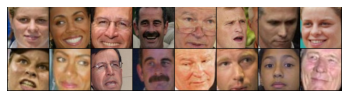

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]]
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.]])


In [ ]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())
print(example_batch[2])


In [ ]:
net = SiameseNetwork().cuda()

criterion = ContrastiveLoss()

optimizer = optim.Adam([
                {'params': net.model_vgg16.features[24:31].parameters()},                       
                {'params': net.model_vgg16.classifier.parameters()}
            ], lr=0.000005)

count_parameters(net)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



The model architecture:

 SiameseNetwork(
  (model_vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   

In [ ]:
save_path=os.path.join(path_lfw_folder,'siameseWithVGG16.pt')

Starting epoch 1
Starting training... 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Starting validation... 
Model saved to ==> ./gdrive/MyDrive/Datasets/siameseWithVGG16.pt
Epoch [1/100],Train Loss: 0.2600, Valid Loss: 0.24187655
Starting epoch 2
Starting training... 
Starting validation... 
Epoch [2/100],Train Loss: 0.2530, Valid Loss: 0.24332074
Starting epoch 3
Starting training... 
Starting validation... 
Model saved to ==> ./gdrive/MyDrive/Datasets/siameseWithVGG16.pt
Epoch [3/100],Train Loss: 0.2526, Valid Loss: 0.23928611
Starting epoch 4
Starting training... 
Starting validation... 
Epoch [4/100],Train Loss: 0.2518, Valid Loss: 0.24233078
Starting epoch 5
Starting training... 
Starting validation... 
Model saved to ==> ./gdrive/MyDrive/Datasets/siameseWithVGG16.pt
Epoch [5/100],Train Loss: 0.2517, Valid Loss: 0.24035744
Starting epoch 6
Starting training... 
Starting validation... 
Model saved to ==> ./gdrive/MyDrive/Datasets/siameseWithVGG16.pt
Epoch [6/100],Train Loss: 0.2516, Valid Loss: 0.23994031
Starting epoch 7
Starting training... 
Starting validation.

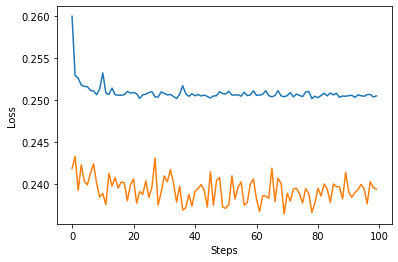

In [ ]:
train_loss_his,val_loss_his,mx_val_accuracy_train,validation_accu=train(net,train_loader,val_loader,Config().train_number_epochs,criterion,save_path,optimizer)

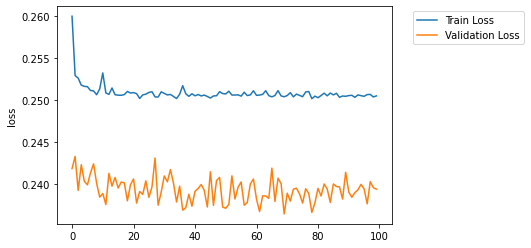

In [ ]:
# lr=    batch=   epoch=
plt.ylabel('loss')
plt.plot(train_loss_his, label='Train Loss')
plt.plot(val_loss_his, label='Validation Loss')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

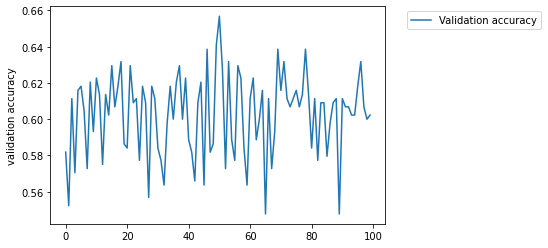

In [ ]:
# lr=    batch=   epoch=
plt.ylabel('validation accuracy')
plt.plot(validation_accu, label='Validation accuracy')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [ ]:
print("Maximum validation accuracy: ",mx_val_accuracy_train)

Maximum validation accuracy:  0.6568181818181819


In [ ]:
def test(model,test_loader):
    with torch.no_grad():
      model.eval()
      correct=0
      cnt=0
      bth_no=0
      print("Strating ...")
      for i,data in enumerate(test_loader,0):
        bth_no+=1
        print("Batch no: ",bth_no)
        
        imgs1,imgs2,labels=data
        
        imgs1=imgs1.to(device=device, dtype=torch.float)
        imgs2=imgs2.to(device=device, dtype=torch.float)
        labels=labels.to(device=device, dtype=torch.float)

        output1,output2=model(imgs1,imgs2)

        dist = F.pairwise_distance(output1, output2)     # dist will be a 1d array with each element representing dist for each pair  

        noImg,noCrt= calculate_accuracy(labels,dist)
        cnt+=noImg
        correct+=noCrt

    test_accuracy= correct/cnt
    print("Finished!!!")

    return test_accuracy


In [ ]:
root_path_to_saved_models=path_lfw_folder
path_to_model_from_saved_model_dir='siameseWithVGG16.pt'
path_to_chosen_model= os.path.join(root_path_to_saved_models,path_to_model_from_saved_model_dir)  #################
# print(path_to_chosen_model )

In [ ]:
load_model= SiameseNetwork().cuda()
load_optimizer = optim.Adam([
                {'params': load_model.model_vgg16.features[24:31].parameters()},                    
                {'params': load_model.model_vgg16.classifier.parameters()}
            ], lr=0.000005)
mx_val_acc=load_checkpoint(load_model,load_optimizer,path_to_chosen_model)



siamese_dataset_test = SiameseNetworkDataset(Config().testing_txt,Config().testing_dir,
                                        transform=transforms.Compose([transforms.Resize(( 128,128 )),
                                                                      transforms.ToTensor()
                                                  ])
                                        )
test_loader = DataLoader(siamese_dataset_test , shuffle=True, batch_size=1,  num_workers=2)

train_accuracy= test(load_model,train_loader)
test_accuracy=test(load_model,test_loader)


print("Train accuracy is: ",100*train_accuracy)
print("Test accuracy is: ",100*test_accuracy)
print("Max val accuracy during training: ",100*mx_val_acc)

Model loaded from <== ./gdrive/MyDrive/Datasets/siameseWithVGG16.pt
Strating ...
Batch no:  1
Batch no:  2
Batch no:  3
Batch no:  4
Batch no:  5
Batch no:  6
Batch no:  7
Batch no:  8
Batch no:  9
Batch no:  10
Batch no:  11
Batch no:  12
Batch no:  13
Batch no:  14
Batch no:  15
Batch no:  16
Batch no:  17
Batch no:  18
Batch no:  19
Batch no:  20
Batch no:  21
Batch no:  22
Batch no:  23
Batch no:  24
Batch no:  25
Batch no:  26
Batch no:  27
Batch no:  28
Batch no:  29
Batch no:  30
Batch no:  31
Batch no:  32
Batch no:  33
Batch no:  34
Batch no:  35
Batch no:  36
Batch no:  37
Batch no:  38
Batch no:  39
Batch no:  40
Batch no:  41
Batch no:  42
Batch no:  43
Batch no:  44
Batch no:  45
Batch no:  46
Batch no:  47
Batch no:  48
Batch no:  49
Batch no:  50
Batch no:  51
Batch no:  52
Batch no:  53
Batch no:  54
Batch no:  55
Finished!!!
Strating ...
Batch no:  1
Batch no:  2
Batch no:  3
Batch no:  4
Batch no:  5
Batch no:  6
Batch no:  7
Batch no:  8
Batch no:  9
Batch no:  10
Ba

In [ ]:
print("Train accuracy is: ",100*train_accuracy)
print("Test accuracy is: ",100*test_accuracy)
print("Max val accuracy during training: ",100*mx_val_acc)

Train accuracy is:  73.92045454545455
Test accuracy is:  60.6
Max val accuracy during training:  65.68181818181819
